# Training functions

In [ ]:
%matplotlib inline

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import os
import time
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from google.colab import output
from scipy.io import savemat
output.enable_custom_widget_manager()


class aux_bot():

    def __init__(self,drive_path = None, data_path = None,
                 train_forward = False, train_inverse = False,
                 normalize=True):
        # Setup device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("Connected: ", self.device)
        self.data_path = data_path
        self.drive_path = drive_path
        self.model_path = None
        self.normalize = normalize

        # Parameter indicies
        self.m_inputs = 5
        self.n_outputs = 7
        self.motor_slice = slice(0,self.m_inputs)
        self.end_slice = slice(self.m_inputs,self.m_inputs+self.n_outputs)
        self.end_slice_xyz = slice(self.m_inputs,self.m_inputs+3)
        self.input_size = self.motor_slice.stop - self.motor_slice.start
        self.output_size = self.end_slice.stop - self.end_slice.start

        # Constant for forward model
        self.BATCH_SIZE = 16
        self.EPOCHS = 100
        self.LEARNING_RATE = 0.0005
        self.MOMENTUM = 0.9
        self.WEIGHT_DECAY = 0
        self.DROPOUT = 0
        self.LAYERS = 1

        # Upload data as fixed length trajectories instead of single points
        self.SEQ_LENGTH = 32
        self.upload_data(drive_path+data_path,batch_size = self.BATCH_SIZE,seq_length = self.SEQ_LENGTH)

        # Train forward model
        if  train_forward:
            self.fk_net = self.forward_net(inputs = self.input_size,
                                           hidden_lstm = 512,
                                           hidden = 1552,
                                           outputs = self.output_size,
                                           num_layers = 1,
                                           dropout = self.DROPOUT,
                                           device = self.device)
            # Train and evaluate
            self.train_forward(self.fk_net,self.EPOCHS,self.LEARNING_RATE,self.MOMENTUM,self.WEIGHT_DECAY,annealing=True)
            self.eval_model_forward(self.fk_net,self.fk_train_loss)

        # Load forward model instead
        if not train_forward:
            self.fk_net = self.forward_net(hidden_lstm=512, hidden=1552)
            self.fk_net.load_state_dict(torch.load(drive_path + '/models/forward_2023_08_22-19_21_14_8.550mm'))
            self.fk_net.eval()
            print("[aux_net] Forward model succesfully loaded")

        # Constant for inverse model
        self.EPOCHS = 100
        self.LEARNING_RATE = 0.001
        self.MOMENTUM = 0.9
        self.DROPOUT = 0
        self.LAYERS = 1

        # Train inverse model
        if  train_inverse:
            self.ik_net = self.inverse_net(hidden=1552,
                                           hidden_lstm = 512,
                                           inputs=self.output_size,
                                           outputs=self.input_size,
                                           device=self.device,
                                           dropout=self.DROPOUT,
                                           num_layers=self.LAYERS,
                                           linear_depth=3)
            # Train and evaluate
            self.train_inverse(self.ik_net,self.EPOCHS,self.LEARNING_RATE,self.MOMENTUM,self.WEIGHT_DECAY,annealing=True)
            self.eval_model_inverse(self.ik_net,self.ik_train_loss)

        # Load forward model instead
        if not train_inverse:
            self.ik_net = self.inverse_net(hidden_lstm=512, hidden=1552,device=self.device,linear_depth=3)
            self.ik_net.load_state_dict(torch.load(drive_path + '/models/inverse_2023_09_13-17_35_20_4.056pwm'))
            self.ik_net.eval()
            self.ik_net.to(self.device)
            print("[aux_net] Inverse model succesfully loaded")

    # Apply data normalization
    def normalize_data(self,data,d_type="full"):
        if d_type == "full":
            data = (data-self.min_scale)/(self.max_scale-self.min_scale)
        elif d_type == "motor":
                data = (data-self.min_scale[self.motor_slice])/(self.max_scale[self.motor_slice]-self.min_scale[self.motor_slice])
        elif d_type == "end_full":
            data = (data-self.min_scale[self.end_slice])/(self.max_scale[self.end_slice]-self.min_scale[self.end_slice])
        return data

    # Return data to original units
    def denormalize_data(self, data, d_type="full"):
        if d_type == "full":
            data = data*(self.max_scale-self.min_scale)+self.min_scale
        elif d_type == "motor":
                data = data*(self.max_scale[self.motor_slice]-self.min_scale[self.motor_slice])+self.min_scale[self.motor_slice]
        elif d_type == "end_full":
            data = data*(self.max_scale[self.end_slice]-self.min_scale[self.end_slice])+self.min_scale[self.end_slice]
        return data

    class SequenceDataset(Dataset):
        def __init__(self, data_array, input_range, output_range, sequence_length=5,
                     shuffle=True, train=False, test=False, split=0.8,inverse=False):
            self.shuffle = shuffle
            self.sequence_length = sequence_length
            self.train = train
            self.test = test
            self.split = split
            if not inverse:
                self.y = torch.tensor(data_array[:, output_range]).float()
                self.X = torch.tensor(data_array[:, input_range]).float()
            else:
                self.y = torch.tensor(data_array[:, input_range]).float()
                self.X = torch.tensor(data_array[:, output_range]).float()
            self.N = self.X.shape[0]

            # Data shuffling
            if shuffle == True:
                torch.manual_seed(7)
                self.idx = torch.randperm(self.N)

            # Handle train-test split
            if self.train:
                self.N = int(self.N*self.split)
                if self.shuffle: self.idx = self.idx[0:self.N]
            if self.test:
                self.N = int(self.N*(1-self.split))
                if self.shuffle: self.idx = self.idx[-self.N:]

        def __len__(self):
            return self.N

        def __getitem__(self, i):
            assert 0 <= i < self.N, "Index out of bounds for sequence"

            if self.shuffle: i = self.idx[i]

            if i >= self.sequence_length - 1:
                i_start = i - self.sequence_length + 1
                x = self.X[i_start:(i + 1), :]
            else:
                padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
                x = self.X[0:(i + 1), :]
                x = torch.cat((padding, x), 0)

            return x, self.y[i]

        def get_all_items(self):
            Xs, Ys = [], []
            for i in range(self.N):
                x, y = self.__getitem__(i)
                Xs.append(x)
                Ys.append(y)
            return torch.stack(Xs), torch.stack(Ys)

    # Uploads training data
    def upload_data(self, data_path, trim_length = None, batch_size = 1, seq_length = 1):
        '''
        Inputs in data are motor positions [dtm_13, dtm_24, de_13, de_24, d_l]
        Out positions [x_top (0), y_top (1), z_top (2), qx_top (3), qy_top (4), qz_top (5), qw_top (6)]
        '''
        # Upload and convert units from m to mm
        self.data = np.loadtxt(data_path, skiprows = 1, delimiter=',', dtype = 'float32',
                               usecols = tuple(range(2, 2 + self.input_size + self.output_size)))
        self.data[:,self.end_slice_xyz] *= 10e2

        print("Inputs: ", self.data[0:3,self.motor_slice,])
        print("Outputs: ", self.data[0:3,self.end_slice,])

        self.min_scale = np.amin(self.data,0)
        self.max_scale = np.amax(self.data,0)

        if self.normalize: self.data = self.normalize_data(self.data)

        # FORWARD train sequences
        self.forward_train_data = self.SequenceDataset(self.data,
                                                        input_range = self.motor_slice,
                                                        output_range = self.end_slice,
                                                        sequence_length = seq_length,
                                                        shuffle = True,
                                                        train = True,
                                                        inverse = False)

        # FORWARD test sequences
        self.forward_test_data = self.SequenceDataset(self.data,
                                                        input_range = self.motor_slice,
                                                        output_range = self.end_slice,
                                                        sequence_length = seq_length,
                                                        shuffle = True,
                                                        test = True,
                                                        inverse = False)

        # Set up FORWARD data loader
        self.forward_train_loader = torch.utils.data.DataLoader(self.forward_train_data, batch_size = batch_size)
        self.forward_test_loader = torch.utils.data.DataLoader(self.forward_test_data, batch_size = batch_size)

        # INVERSE train sequences
        self.inverse_train_data = self.SequenceDataset(self.data,
                                                        input_range = self.motor_slice,
                                                        output_range = self.end_slice,
                                                        sequence_length = seq_length,
                                                        shuffle = True,
                                                        train = True,
                                                        inverse = True)

        # INVERSE test sequences
        self.inverse_test_data = self.SequenceDataset(self.data,
                                                        input_range = self.motor_slice,
                                                        output_range = self.end_slice,
                                                        sequence_length = seq_length,
                                                        shuffle = True,
                                                        test = True,
                                                        inverse = True)

        # Set up INVERSE data loader
        self.inverse_train_loader = torch.utils.data.DataLoader(self.inverse_train_data, batch_size=batch_size)
        self.inverse_test_loader = torch.utils.data.DataLoader(self.inverse_test_data, batch_size=batch_size)

        # Save our FORWARD and INVERSE test data to plot performance
        X_test_forward, Y_test_forward = self.forward_test_data.get_all_items()
        X_test_inverse, Y_test_inverse = self.inverse_test_data.get_all_items()
        sub_path = self.drive_path + '/data/subset/' + self.data_path.split('/')[2]
        savemat(sub_path.split('.')[0] + '.mat',{'X_test_forward' : X_test_forward,
                                                 'Y_test_forward' : Y_test_forward,
                                                 'X_test_inverse' : X_test_inverse,
                                                 'Y_test_inverse' : Y_test_inverse})


    ########################
    # FORWARD NETWORK
    ########################


    class forward_net(nn.Module):
        def __init__(self, inputs=5, hidden_lstm=512, hidden=1024, outputs=7,num_layers=1,dropout=0,device=None):
            super().__init__()
            self.device = device

            self.lstm = nn.LSTM(
            input_size=inputs,
            hidden_size=hidden_lstm,
            batch_first=True,
            num_layers=num_layers,
            )

            self.fc1 = nn.Linear(2 * hidden_lstm, hidden)
            self.fc2 = nn.Linear(hidden, hidden)
            self.fc3 = nn.Linear(hidden, outputs)

            self.input_size = inputs
            self.hidden_size = hidden
            self.hidden_lstm_size = hidden_lstm
            self.output_size = outputs
            self.num_layers = num_layers
            self.dropout = nn.Dropout(dropout)

        def forward(self,x):
            batch_size = x.shape[0]
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_lstm_size).requires_grad_().to(self.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_lstm_size).requires_grad_().to(self.device)

            _, (hn, cn) = self.lstm(x, (h0, c0))

            y = torch.cat((hn[0], cn[0]), dim=1)

            y = F.relu(y)
            y = self.fc1(y)
            y = F.relu(y)
            y = self.fc2(y)
            y = F.relu(y)
            y = self.fc3(y)

            return y

    def quaternion_angular_error(self, q1, q2):
        # Determine if input is numpy or torch
        if isinstance(q1, np.ndarray):
            # For NumPy arrays
            dot_product = np.sum(q1 * q2, axis=1)
            dot_product = np.clip(dot_product, -1.0, 1.0)
            absolute_dot_product = np.abs(dot_product)
            half_angle = np.arccos(absolute_dot_product)
        elif isinstance(q1, torch.Tensor):
            # For PyTorch tensors
            dot_product = (q1 * q2).sum(dim=1).clamp(-1.0, 1.0)
            absolute_dot_product = torch.abs(dot_product)
            half_angle = torch.acos(absolute_dot_product)
        else:
            raise TypeError("Unsupported input type. Expected numpy array or torch tensor.")

        # Double to get full angle, return in degrees
        return 2 * half_angle * (180.0 / np.pi)

    # Custom loss function
    def custom_loss(self,y_pred, y_measured):
        mse = nn.MSELoss()
        mse_loss = mse(y_pred[:, :3], y_measured[:, :3])
        quaternion_loss = self.quaternion_angular_error(y_pred[:, 3:], y_measured[:, 3:]).mean()
        return (mse_loss + 0.5*quaternion_loss)/1.5

    # Training function
    def train_forward(self,fk_net,epochs=10, lr=0.01, momentum=0.9, decay=0.0, verbose=1,annealing=True):
        fk_net.to(self.device)
        losses = []
        criterion = nn.MSELoss()
        self.optimizer = optim.Adam(fk_net.parameters(), lr, weight_decay=decay)

        # Aneal learning rate
        if annealing:
            scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)

        for epoch in range(epochs):
            sum_loss = 0
            loss_list = []
            i = 0
            for X, y in self.forward_train_loader:
                X, y = X.to(self.device), y.to(self.device)

                # Reset gradients
                self.optimizer.zero_grad()

                # Run network forward, backward, and then update
                y_pred = fk_net(X)
                loss = self.custom_loss(y_pred,y)
                loss.backward()
                self.optimizer.step()

                # Track performance
                loss_list.append(loss.item())
                sum_loss += loss.item()

                if i % 100 == 99:
                    if verbose:
                        print('(Epoch {}, Iter {}) loss: {:.6f}'.format(epoch + 1, i + 1, sum_loss / 100))
                    sum_loss = 0
                i+=1
            if annealing:
                scheduler.step()
            losses.append(np.mean(loss_list))
            loss_list = []
        self.fk_train_loss = losses


    # Determine model error for predicting end effector pose
    def test_forward(self,fk_net,data='train'):
        accuracy = []
        err = np.array([])
        q_err = np.array([])

        # Create data loader
        if data == 'train': loader = self.forward_train_loader
        if data == 'test': loader = self.forward_test_loader

        # Run through the data
        for X, y in loader:
            X, y = X.to(self.device), y.to(self.device)

            y_pred = fk_net(X)

            # Convert back to CPU side
            y_pred = y_pred.numpy(force=True)
            y = y.numpy(force=True)

            if self.normalize:
                y_pred = self.denormalize_data(y_pred,"end_full")
                y = self.denormalize_data(y,"end_full")

            # Calculate postional error
            e = y_pred[:,0:3]-y[:,0:3]
            error = np.linalg.norm(e,axis = 1).flatten()
            accuracy.append(np.mean(error))
            err = np.append(err,error)

            # Calculate orientation error
            q_e = self.quaternion_angular_error(y_pred[:, 3:], y[:, 3:])
            q_error = q_e.flatten()
            q_err = np.append(q_err,q_error)

        return np.mean(accuracy), err, q_err

    # Plots the test accuracy of the model
    def eval_model_forward(self,fk_net,loss):
        # Plot losses during training
        plt.close('all')
        f = plt.figure()
        f.set_size_inches(16,4)
        ax1 = f.add_subplot(1,3,1)
        ax2 = f.add_subplot(1,3,2)
        ax3 = f.add_subplot(1,3,3,projection='3d')

        # Plot training loss
        ax1.plot(np.log10(loss),linewidth = 2)
        ax1.set_xlabel("Epochs",fontsize = 14)
        ax1.set_ylabel("log10(Loss)",fontsize = 14)
        ax1.set_title("Train Loss (Forward)",fontsize = 16)
        ax1.grid()

        # Determine train and test accuracy
        test_accuracy,test_error, test_q_error = self.test_forward(fk_net,data='test')
        train_accuracy, train_error, train_q_error = self.test_forward(fk_net,data='train')

        print("Train accuracy {:.10f} mm Test accuracy: {:.10f} mm".format(train_accuracy,test_accuracy))

        # Show testing accuracy
        ax2.hist(test_error,20)
        ax2.set_xlabel("Error (mm)",fontsize = 14)
        ax2.set_ylabel("Count",fontsize = 14)
        ax2.set_title("Positional Error for Test Data",fontsize = 16)
        ax2.grid()

        # Create a colormap and a normalize function based on the errors' range
        colormap = cmap=plt.cm.jet
        xyz_quat = np.zeros((len(self.forward_test_data),7))

        for i in range(len(self.forward_test_data)):
            X,y = self.forward_test_data[i]
            y = y.numpy(force=True)
            y = self.denormalize_data(y,"end_full")
            xyz_quat[i,:] = y

        # Create scatter plot of distance errors
        p = ax3.scatter(xyz_quat[:,0], xyz_quat[:,2], xyz_quat[:,1], c = test_error, cmap=plt.cm.jet,vmin=0,vmax=0.65*np.max(test_error), alpha=0.2)
        ax3.view_init(45, 45)
        cb = f.colorbar(p)
        cb.set_label("Error (mm)")
        ax3.set_xlabel("xe",fontsize = 14)
        ax3.set_ylabel("ye",fontsize = 14)
        ax3.set_zlabel("ze",fontsize = 14)
        ax3.set_title("Aux-Net Forward Model Performance",fontsize = 16)
        ax3.grid()
        plt.tight_layout()
        plt.show()

        # Save model
        model_name = 'forward_' + time.strftime('%Y_%m_%d-%H_%M_%S_') + '{:.3f}mm'.format(test_accuracy)
        torch.save(fk_net.state_dict(),self.drive_path + '/models/' + model_name)

        savemat(self.drive_path + "/metrics/forward_" + model_name,{'test_error' : test_error,
                                                                    'test_q_error' : test_q_error})

        return test_accuracy


    #########################
    ## INVERSE NETWORK
    #########################
    class inverse_net(nn.Module):
        def __init__(self, inputs=7, hidden_lstm=512, hidden=1024, outputs=5, num_layers=1, dropout=0.1, device=None, linear_depth = None):
            super().__init__()

            self.device = device

            self.lstm = nn.LSTM(
            input_size=inputs,
            hidden_size=hidden_lstm,
            batch_first=True,
            num_layers=num_layers,
            )

            self.drop = nn.Dropout(dropout)

            # Default size
            if linear_depth == None:
                self.fc1 = nn.Linear(hidden_lstm,hidden)
                self.fc2 = nn.Linear(hidden,hidden)
                self.fc3 = nn.Linear(hidden,outputs)

            # Explore different sizes
            else:
                self.linear_layers = nn.ModuleList()  # Use nn.ModuleList
                if linear_depth == 1:
                    self.linear_layers.append(nn.Linear(2 * hidden_lstm, outputs))
                else:
                    self.linear_layers.append(nn.Linear(2 * hidden_lstm, hidden))
                    for _ in range(1, linear_depth - 1):
                        self.linear_layers.append(nn.Linear(hidden, hidden))
                    self.linear_layers.append(nn.Linear(hidden, outputs))

            self.input_size = inputs
            self.hidden_size = hidden
            self.hidden_lstm_size = hidden_lstm
            self.output_size = outputs
            self.num_layers = num_layers
            self.dropout = dropout
            self.linear_depth = linear_depth

        def forward(self,y):

            batch_size = y.shape[0]
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_lstm_size).requires_grad_().to(self.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_lstm_size).requires_grad_().to(self.device)

            _, (hn, cn) = self.lstm(y, (h0, c0))
            x = torch.cat((hn[0], cn[0]), dim=1)

            x = self.drop(x)

            # Default architecture
            if self.linear_depth == None:
                x = F.relu(x)
                x = self.fc1(x)
                x = F.relu(x)
                x = self.fc2(x)
                x = F.relu(x)
                x = self.fc3(x)

            # n-dimensional
            else:
                for fc in self.linear_layers:
                    x = F.relu(x)
                    x = fc(x)

            return x

    # Training function
    def train_inverse(self,ik_net,epochs=10, lr=0.01, momentum=0.9, decay=0.0, verbose=1, annealing=True):
        ik_net.to(self.device)
        losses = []
        criterion = nn.MSELoss()
        self.optimizer = optim.Adam(ik_net.parameters(), lr, weight_decay=decay)

        # Anneal the learing rate over time
        if annealing:
            scheduler = optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.9)

        for epoch in range(epochs):
            sum_loss = 0
            loss_list = []
            i = 0
            for X, y in self.inverse_train_loader:
                X, y = X.to(self.device), y.to(self.device)

                # Reset gradients
                self.optimizer.zero_grad()

                # Run network forward, backward, and then update
                y_pred = ik_net(X)
                loss = criterion(y_pred,y)
                loss.backward()
                self.optimizer.step()

                # Track performance
                loss_list.append(loss.item())
                sum_loss += loss.item()
                if i % 100 == 99:
                    if verbose:
                        print('(Epoch {}, Iter {}) loss: {:.6f}'.format(epoch + 1, i + 1, sum_loss / 100))
                    sum_loss = 0
                i += 1
            if annealing:
                scheduler.step()
            losses.append(np.mean(loss_list))
            loss_list = []
        self.ik_train_loss = losses

    # Determine model error from predicting motor inputs
    def test_inverse(self,ik_net,data='train'):
        accuracy = []
        err = np.array([])
        dist = np.array([])

        # Create data loader
        if data == 'train': loader = self.inverse_train_loader
        if data == 'test': loader = self.inverse_test_loader

        # Run through the data
        for X, y in loader:
            X, y = X.to(self.device), y.to(self.device)

            # Run network forward, backward, and then update
            y_pred = ik_net(X)

            # Denormalize data to find error
            if self.normalize:
                y_pred = self.denormalize_data(y_pred.numpy(force=True),"motor")
                y = self.denormalize_data(y.numpy(force=True),"motor")
                X = self.denormalize_data(X.numpy(force=True),"end_full")

            # Calculate error
            e = y_pred-y
            error = np.linalg.norm(e,axis = 1).flatten()
            accuracy.append(np.mean(error))
            err = np.append(err,error)

            # Record distance of this trajectory
            X = X[:,:,:3]
            diffs = np.diff(X, axis=1)  # This will reduce the 2nd dimension by 1
            point_dist = np.linalg.norm(diffs, axis=-1)
            seq_dis = np.sum(point_dist, axis=1)
            dist = np.append(dist, seq_dis)

        return np.mean(accuracy), err, dist

    # Plots the test accuracy of the model
    def eval_model_inverse(self,ik_net,loss):
        # Plot losses during training
        f = plt.figure()
        f.set_size_inches(20,5)
        ax1 = f.add_subplot(1,3,1)
        ax2 = f.add_subplot(1,3,2)
        ax3 = f.add_subplot(1,3,3,projection='3d')

        # Plot training loss
        ax1.plot(np.log10(loss),linewidth = 2)
        ax1.set_xlabel("Epochs",fontsize = 14)
        ax1.set_ylabel("log10(Loss)",fontsize = 14)
        ax1.set_title("Train Loss (Inverse)",fontsize = 16)
        ax1.grid()

        # Determine train and test accuracy
        test_accuracy,test_error,test_dist = self.test_inverse(ik_net,data='test')
        train_accuracy, train_error,train_dist = self.test_inverse(ik_net,data='train')
        self.test_accuracy = test_accuracy

        print("Train accuracy {:.10f} pwm Test accuracy: {:.10f} pwm".format(train_accuracy,test_accuracy))

        # Show testing accuracy
        ax2.hist(test_error,int(np.sqrt(len(test_error))))
        ax2.set_xlabel("Error (pwm)",fontsize = 14)
        ax2.set_ylabel("Count",fontsize = 14)
        ax2.set_title("PWM Error for Test Data",fontsize = 16)
        ax2.set_xlim(0,25)
        ax2.grid()

        # Create a colormap and a normalize function based on the errors' range
        colormap = cmap=plt.cm.jet
        norm = Normalize(vmin=test_error.min(), vmax=0.6*test_error.max())

        for i in range(len(self.inverse_test_data)):
            X,y = self.inverse_test_data[i]
            X = X.numpy(force=True)
            X = self.denormalize_data(X,"end_full")
            color = colormap(norm(test_error[i]))
            plt.plot(X[:,0],X[:,2],X[:,1],marker='o', color=color, alpha=0.2)

        # Plot formatting
        ax3.view_init(45, 45)
        cb = f.colorbar(plt.cm.ScalarMappable(cmap=colormap, norm=norm), ax=ax3, shrink=0.6)
        cb.set_label("Error (pwm)")
        ax3.set_xlabel("xe",fontsize = 14)
        ax3.set_ylabel("ye",fontsize = 14)
        ax3.set_zlabel("ze",fontsize = 14)
        ax3.set_title("Aux-Net Inverse Model Performance",fontsize = 16)
        ax3.grid()
        plt.tight_layout()
        plt.show()

        # Save model
        torch.save(ik_net.state_dict(),self.drive_path +'/models/inverse_'+time.strftime('%Y_%m_%d-%H_%M_%S_') + '{:.3f}pwm'.format(test_accuracy))

        f = plt.figure()
        plt.scatter(train_dist,train_error)
        plt.scatter(test_dist,test_error)
        plt.legend(["test","train"])
        plt.xlabel("trajectory distance (mm)",fontsize = 14)
        plt.ylabel("inverse model error (pwm)",fontsize = 14)
        plt.show()

        return test_accuracy

    # Train and validation for Bayesian optimization of model
    def train_validate(self, lr: float, hidden_lstm: float, hidden: float):

            hidden_lstm = int(hidden_lstm)
            hidden = int(hidden)

            self.optima_net = self.inverse_net(hidden=hidden,
                                    hidden_lstm = hidden_lstm,
                                    inputs=self.output_size,
                                    outputs=self.input_size,
                                    device=self.device,
                                    dropout=self.DROPOUT,
                                    num_layers=1)

            # Train and evaluate
            self.train_inverse(self.optima_net,self.EPOCHS,lr,self.MOMENTUM,self.WEIGHT_DECAY,annealing=True,verbose=0)
            validation,_,_ = self.test_inverse(self.optima_net,data="test")

            return -validation

    # Run inverse prediction
    def inverse_prediction(self,input_path=None,output_path=None):
        with torch.no_grad():
            # Find end effector position we want to predict for inverse verification
            if input_path == None:

                n_points = 7500

                prediction_data = self.SequenceDataset(self.data[0:n_points,:],
                                                       input_range = self.end_slice,
                                                       output_range = self.motor_slice,
                                                       sequence_length = self.SEQ_LENGTH,
                                                       shuffle = False,
                                                       train = False,
                                                       inverse = False)
                # Gather all sequence data
                X, y = prediction_data.get_all_items()
                Y_pred = self.ik_net(X.to(self.device))

                # Create numpy arrays
                Y_pred = Y_pred.cpu()
                Y_pred = self.denormalize_data(Y_pred.numpy(),"motor")
                y = self.denormalize_data(y.numpy(),"motor")

                print("Predicted: ", Y_pred[0:10,:])
                print("Measured: ", y[0:10,:])

                np.savetxt(self.drive_path+"/input_regression_7500.csv",Y_pred,delimiter=",",header="dtm_13,dtm_24,de_13,de_24,dl",comments='')

            # Generate motor trajectory
            else:
                traj = torch.from_numpy(np.loadtxt(input_path,skiprows = 1,delimiter=',',dtype = 'float32',usecols = tuple(range(0,7))))
                traj = self.normalize_data(traj,"end_full")

                x_pred = self.inverse_model(traj.to(self.device))
                x_pred = x_pred.cpu()
                x_pred = self.denormalize_data(x_pred,"motor").numpy(force=True)

                np.savetxt(output_path,x_pred,delimiter=",",header="dtm_13,dtm_24,de_13,de_24,dl",comments='')
                print("Trajectory saved!")



# Function for Trajectory Interpolation

In [ ]:
!pip install pyquaternion
import csv
import numpy as np
from pyquaternion import Quaternion
from scipy.interpolate import interp1d

def interpolate_trajectory(input_filename, output_filename, dist_param):
    with open(input_filename, 'r') as f:
        reader = csv.reader(f)
        # Skip the header
        next(reader)
        data = list(reader)

    # Convert data to float
    data = np.array(data, dtype=float)

    # Get positions and quaternions
    pos = data[:, :3]
    quats = [Quaternion(q) for q in data[:, 3:]]

    # Compute distances between consecutive positions
    dists = np.sqrt(np.sum(np.diff(pos, axis=0)**2, axis=1))
    dists = np.insert(dists, 0, 0)  # first distance is 0

    # Compute cumulative distances along the path
    cum_dists = np.cumsum(dists)

    # Compute total number of interpolated points
    total_dist = cum_dists[-1]
    num_interp_points = int(np.ceil(total_dist / dist_param))

    # Create array for interpolated distances
    interp_dists = np.linspace(0, total_dist, num_interp_points)

    # Interpolate positions
    interp_pos = np.zeros((num_interp_points, 3))
    for i in range(3):
        interp_func = interp1d(cum_dists, pos[:, i])
        interp_pos[:, i] = interp_func(interp_dists)

    # Get the original index for each interpolated point
    interp_indices = np.searchsorted(cum_dists, interp_dists) - 1

    # Interpolate quaternions using pyquaternion's Quaternion class
    interp_quats = np.zeros((num_interp_points, 4))
    epsilon = 1e-10  # Small constant to avoid division by zero
    for i in range(num_interp_points - 1):
        fraction = (interp_dists[i] - cum_dists[interp_indices[i]]) / (cum_dists[interp_indices[i+1]] - cum_dists[interp_indices[i]] + epsilon)
        interp_quats[i] = Quaternion.slerp(quats[interp_indices[i]], quats[interp_indices[i+1]], fraction).elements

    # Assign the last original quaternion to the last interpolated point
    interp_quats[-1] = quats[-1].elements

    interp_dists += 1

    # Prepare data for writing to csv
    output_data = np.hstack((interp_pos, interp_quats, interp_indices.reshape(-1, 1)))

    with open(output_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["x_end", "y_end", "z_end", "qx_end", "qy_end", "qz_end", "qw_end", "orig_index"])
        writer.writerows(output_data)

# Launch aux-bot

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Connected:  cuda:0
Inputs:  [[ 0.         0.         0.         0.         0.       ]
 [ 0.8101009 -1.0041184  1.1364819 -5.0179515  1.4013056]
 [-0.6131911 -1.9974661  2.8804388 -6.3800273  1.8499048]]
Outputs:  [[ 6.9101654e+01  3.2354901e+02  7.4590775e+01 -1.9104969e-02
  -9.8767841e-01  3.7367977e-02  1.5076485e-01]
 [ 7.4509354e+01  3.2411902e+02  7.6167366e+01 -3.4702506e-03
  -9.8758996e-01  4.5616228e-02  1.5024395e-01]
 [ 7.4593063e+01  3.2474231e+02  8.0255966e+01 -4.0545864e-03
  -9.8698211e-01  5.8374155e-02  1.4980762e-01]]
(Epoch 1, Iter 100) loss: 2.592864
(Epoch 1, Iter 200) loss: 0.008264
(Epoch 1, Iter 300) loss: 0.006111
(Epoch 1, Iter 400) loss: 0.003251
(Epoch 1, Iter 500) loss: 0.002359
(Epoch 1, Iter 600) loss: 0.002131
(Epoch 1, Iter 700) loss: 0.001781
(Epoch 2, Iter 100) loss: 0.001564
(Epoch 2, Iter 200) loss: 0.001310
(Epoch 2, Iter 300) loss: 

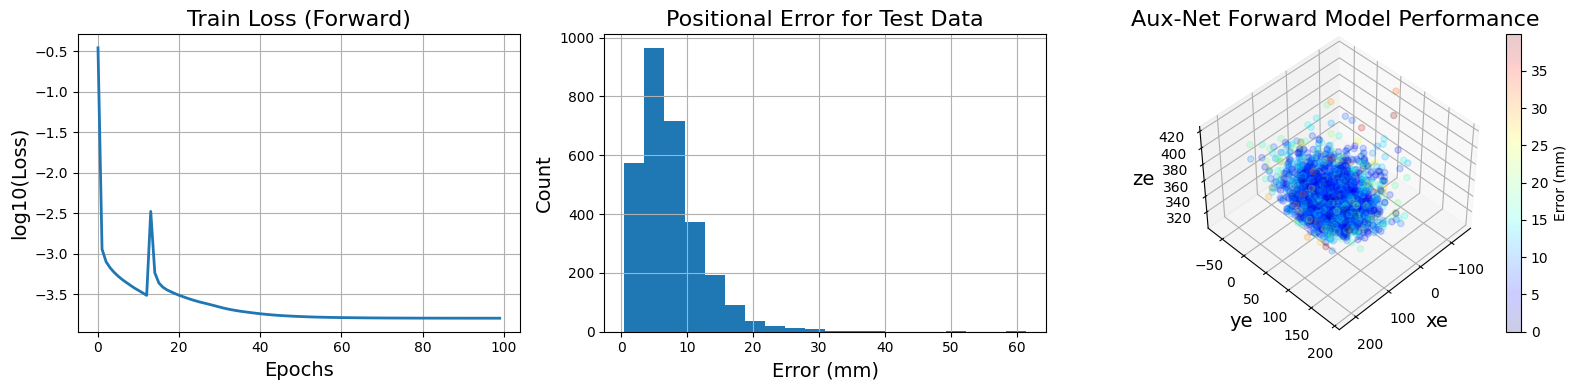

[aux_net] Inverse model succesfully loaded


In [ ]:
from google.colab import drive

drive.mount('/gdrive')
drive_path = '/gdrive/My Drive/Github/aux-net'

# Generate trajectory from waypoints
interpolate_trajectory(drive_path + '/experiments/waypoints_E1.csv',drive_path+'/experiments/trajectory_E1.csv',0.002)

# Create bot and train
bot = aux_bot(drive_path = drive_path, data_path = "/data/15000_pose_data_07_26_2023.csv", train_forward=True, train_inverse=False, normalize=True)

# Use inverse model for regression
# bot.inverse_prediction(input_path = drive_path+'/experiments/trajectory_E1.csv', output_path = drive_path+'/experiments/motor_trajectory_E1.csv')

# Baysiean Optimization

In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from google.colab import drive
import pickle

drive.mount('/gdrive')
drive_path = '/gdrive/My Drive/Github/aux-net'

# Create instance for optimization
bot = aux_bot(drive_path = drive_path, data_path = "/data/15000_pose_data_07_26_2023.csv", train_forward=False, train_inverse=False, normalize=True)

# Define architecture and hyper parameter bounds
pbounds = {
    'lr': (1e-5, 1e-2),
    'hidden_lstm': (32,1024),
    'hidden': (32,2048),
}

Mounted at /gdrive
Connected:  cuda:0
Inputs:  [[ 0.         0.         0.         0.         0.       ]
 [ 0.8101009 -1.0041184  1.1364819 -5.0179515  1.4013056]
 [-0.6131911 -1.9974661  2.8804388 -6.3800273  1.8499048]]
Outputs:  [[ 6.9101654e+01  3.2354901e+02  7.4590775e+01 -1.9104969e-02
  -9.8767841e-01  3.7367977e-02  1.5076485e-01]
 [ 7.4509354e+01  3.2411902e+02  7.6167366e+01 -3.4702506e-03
  -9.8758996e-01  4.5616228e-02  1.5024395e-01]
 [ 7.4593063e+01  3.2474231e+02  8.0255966e+01 -4.0545864e-03
  -9.8698211e-01  5.8374155e-02  1.4980762e-01]]
FORWARD sequences:
(tensor([[0.5544, 0.2315, 0.5764, 0.4341, 0.4955],
        [0.5262, 0.2426, 0.5493, 0.3776, 0.4737],
        [0.5161, 0.2295, 0.4814, 0.3661, 0.4656],
        [0.4604, 0.2582, 0.4149, 0.3470, 0.5028],
        [0.4596, 0.2848, 0.4111, 0.3513, 0.4613],
        [0.4866, 0.3043, 0.3974, 0.3754, 0.4021],
        [0.4566, 0.3384, 0.4116, 0.3539, 0.4055],
        [0.4685, 0.3513, 0.4751, 0.3306, 0.3810],
        [0.5097, 

In [ ]:
# Define optimizer
optimizer = BayesianOptimization(
    f=bot.train_validate,
    pbounds=pbounds,
    random_state=1,
)

# Run optimization
optimizer.maximize(
    init_points=25,
    n_iter=40
)

# Print best parameters
print("Best parameters:", optimizer.max['params'])

# Save results
with open('bayesian_opt_results.pkl', 'wb') as f:
    pickle.dump(optimizer.res, f)

|   iter    |  target   |  hidden   | hidden... |    lr     |
-------------------------------------------------------------
| 1         | -15.59    | 872.7     | 746.6     | 1.114e-05 |
| 2         | -5.235    | 641.5     | 177.6     | 0.0009325 |
| 3         | -4.683    | 407.5     | 374.8     | 0.003974  |
| 4         | -4.846    | 1.118e+03 | 447.8     | 0.006855  |
| 5         | -5.101    | 444.2     | 903.1     | 0.0002836 |
| 6         | -4.702    | 1.384e+03 | 446.0     | 0.005591  |
| 7         | -5.12     | 315.0     | 228.5     | 0.008009  |
| 8         | -4.905    | 1.984e+03 | 342.9     | 0.006926  |
| 9         | -4.43     | 1.799e+03 | 919.4     | 0.0008596 |
| 10        | -5.269    | 110.7     | 200.5     | 0.008783  |
| 11        | -26.79    | 230.3     | 449.7     | 0.009579  |
| 12        | -4.569    | 1.107e+03 | 718.3     | 0.003162  |
| 13        | -4.996    | 1.416e+03 | 859.9     | 0.0001927 |
| 14        | -26.79    | 1.544e+03 | 1.013e+03 | 0.007484  |
| 15    

# GitHub

In [6]:
drive.mount('/gdrive')


%cd '/gdrive/My Drive/Github/aux-net'
!git config --global user.email "kubekk101@gmail.com"
!git config --global user.name "KubaSrc"


NameError: ignored

In [5]:
drive.mount('/gdrive')
%cd '/gdrive/My Drive/Github/aux-net'
!git add -A
!git commit -m "Training on cn and hn. Now exporting validation data."
!git push

NameError: ignored